<p align="center">
  <a href="url"><img src="https://images.unsplash.com/photo-1507720708252-1ddeb1dbff34?ixlib=rb-1.2.1&auto=format&fit=crop&w=1668&q=80" align="middle" height="383" width="640" ></a>
</p>

# Bagaimana Membuat Fully-Connected Image Classifier


Di dalam tutorial, kamu akan melatih sebuah fully-connected neural network untuk melakukan image classification bunga dandelion dan rumput. KIta akan menggunakan Framework Deep Learning TensorFlow untuk membuat neural network dan training/validation dataset. Pertama, silahkan download training and validation data.


### Building the Image Dataset

In [ ]:
!wget --no-check-certificate \
    https://github.com/btphan95/simple-cnn/blob/master/train.zip?raw=true \
    -O /tmp/train.zip

In [ ]:
!wget --no-check-certificate \
    https://github.com/btphan95/simple-cnn/blob/master/valid.zip?raw=true \
    -O /tmp/valid.zip

Codingan Python ini menggunakan OS library untuk melakukan Operating System libraries, memberikan access ke file system dan zipfile library untuk unzip datanya. 

In [ ]:
#Import Library OS/Zipfile
import os
import zipfile

local_zip = '/tmp/train.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/tmp')
local_zip = '/tmp/valid.zip'

zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/tmp')
zip_ref.close()

Isi dari .zip di extract ke directory `/tmp/train`, dimana setiap folder berisi subfolder dengan nama `dandelion` dan `rumput`.

Kita menggunakan [ImageGenerator](https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image/ImageDataGenerator) class untuk membuat secara otomatis dataset train dari directory ini dengan menggunakan subdirectory untuk setiap kelasnya.

Menentukan setiap subdirectory :

In [ ]:
# Directory with our training dandelion pictures
train_dandelion_dir = os.path.join('/tmp/train/dandelion')

# Directory with our training grass pictures
train_grass_dir = os.path.join('/tmp/train/grass')

# Directory with our validation dandelion pictures
valid_dandelion_dir = os.path.join('/tmp/valid/dandelion')

# Directory with our validation grass pictures
valid_grass_dir = os.path.join('/tmp/valid/grass')

Melihat seperti apa nama file di training directory `dandelion` dan `rumput` :

In [ ]:
train_dandelion_names = os.listdir(train_dandelion_dir)
print(train_dandelion_names[:10])

train_grass_names = os.listdir(train_grass_dir)
print(train_grass_names[:10])

validation_dandelion_hames = os.listdir(valid_dandelion_dir)
print(validation_dandelion_hames[:10])

validation_grass_names = os.listdir(valid_grass_dir)
print(validation_grass_names[:10])

Mencari informasi berapa total images dari dandelion dan rumput di directory :

In [ ]:
print('total training dandelion images:', len(os.listdir(train_dandelion_dir)))
print('total training rumput images:', len(os.listdir(train_grass_dir)))
print('total validation dandelion images:', len(os.listdir(valid_dandelion_dir)))
print('total validation rumput images:', len(os.listdir(valid_grass_dir)))

Melihat beberapa pictures untuk mendapatkan sense lebih baik Seperti apa. 
Hal pertama yang dilakukan adalah melakukan konfigurasi matplot parameters:

In [ ]:
%matplotlib inline

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Parameters for our graph; we'll output images in a 4x4 configuration
nrows = 4
ncols = 4

# Index for iterating over images
pic_index = 0

Menampilkan 8 batch dari 8 dandelion and 8 rumput pictures. Kamu bisa melakukan rerun cell kembali untuk melihat fresh batch setiap waktu:

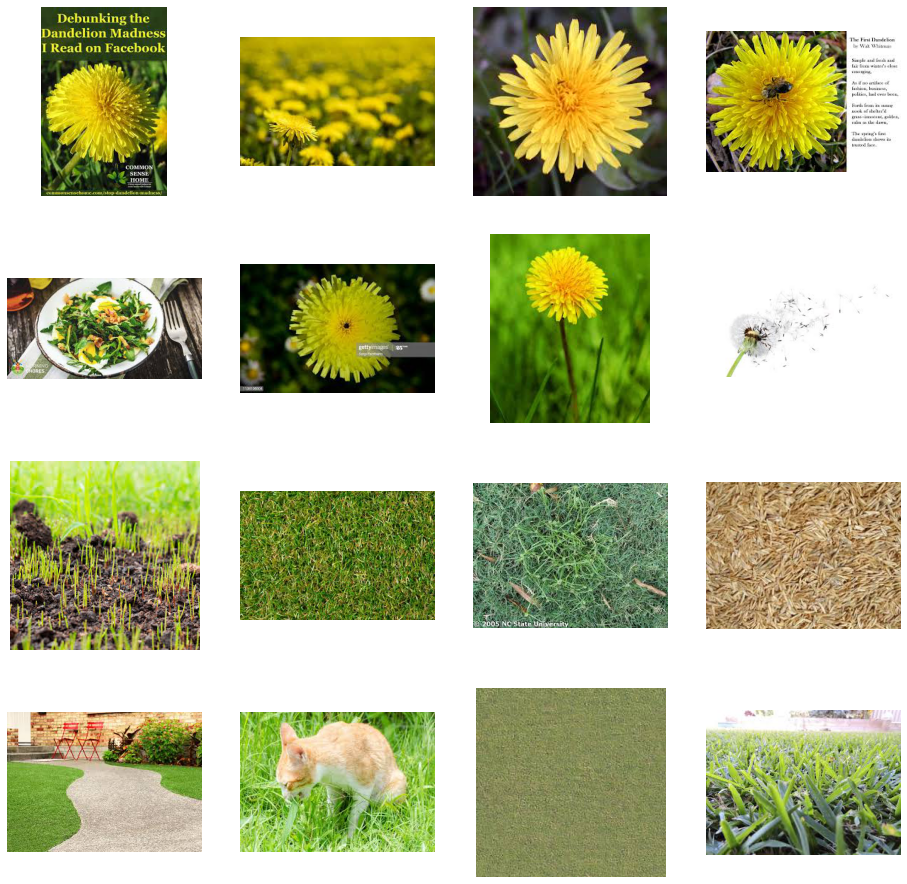

In [ ]:
# Set up matplotlib fig, and size it to fit 4x4 pics
fig = plt.gcf()
fig.set_size_inches(ncols * 4, nrows * 4)

pic_index += 8
next_dandelion_pic = [os.path.join(train_dandelion_dir, fname) 
                for fname in train_dandelion_names[pic_index-8:pic_index]]
next_grass_pic = [os.path.join(train_grass_dir, fname) 
                for fname in train_grass_names[pic_index-8:pic_index]]

for i, img_path in enumerate(next_dandelion_pic + next_grass_pic):
  # Set up subplot; subplot indices start at 1
  sp = plt.subplot(nrows, ncols, i + 1)
  sp.axis('Off') # Don't show axes (or gridlines)

  img = mpimg.imread(img_path)
  plt.imshow(img)

plt.show()


#### Data Preprocessing

Menggunakan `keras.preprocessing.image.ImageDataGenerator` class untuk membuat  train and validation dataset dan normalize data. 
Sangat penting untuk melakukan normalize data karena data akan diproses oleh CNN untuk improve performance secara keseluruhan. Disini kita akan menggunakan `rescale` parameter untuk scale our image pixel values dari [0, 255] ke [0,1].

Disetiap generator, kita menentukan source directory dari images, classes, input image size, batch size (seberapa banyak images yang akan diproses), dan class mode.

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# All images will be rescaled by 1./255
train_datagen = ImageDataGenerator(rescale=1/255)
validation_datagen = ImageDataGenerator(rescale=1/255)

# Flow training images in batches of 120 using train_datagen generator
train_generator = train_datagen.flow_from_directory(
        '/tmp/train/',  # This is the source directory for training images
        classes = ['dandelion', 'grass'],
        target_size=(200, 200),  # All images will be resized to 200x200
        batch_size=120,
        # Use binary labels
        class_mode='binary')

# Flow validation images in batches of 19 using valid_datagen generator
validation_generator = validation_datagen.flow_from_directory(
        '/tmp/valid/',  # This is the source directory for training images
        classes = ['dandelion', 'grass'],
        target_size=(200, 200),  # All images will be resized to 200x200
        batch_size=19,
        # Use binary labels
        class_mode='binary',
        shuffle=False)

Found 999 images belonging to 2 classes.
Found 157 images belonging to 2 classes.




```
# This is formatted as code
```

## Building the Model from Scratch

Memulai menentukan model:

Step 1 import tensorflow.

In [ ]:
import tensorflow as tf
import numpy as np
from itertools import cycle

from sklearn import svm, datasets
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from scipy import interp
from sklearn.metrics import roc_auc_score

Menambahkan Flatten layer yang akan mem-flatten input image, dimana akan dilanjutkan ke next layer, Dense layer, atau fully-connected layer, dengan 128 hidden units. 
Pada tujuan akhirnya adalah untuk  melakukan binary classification, final layer akan menggunakan sigmoid, jadi output dari neural network akan menjadi single scalar antara 0 and 1, dengan melakukan encoding  probability pada image saat ini dengan class 
(class 1 menjadi rumput dan class 0 menjadi dandelion).

In [ ]:
model = tf.keras.models.Sequential([tf.keras.layers.Flatten(input_shape = (200,200,3)), 
                                    tf.keras.layers.Dense(128, activation=tf.nn.relu), 
                                    # tf.keras.layers.Dense(128, activation=tf.nn.relu),
                                    # tf.keras.layers.Dense(32, activation=tf.nn.relu),
                                    tf.keras.layers.Dense(1, activation=tf.nn.sigmoid)])

The model.summary() method call prints a summary of the NN 

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 120000)            0         
_________________________________________________________________
dense (Dense)                (None, 128)               15360128  
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 129       
Total params: 15,360,257
Trainable params: 15,360,257
Non-trainable params: 0
_________________________________________________________________


Kolom "output shape"  menampilkan transformasi dari setiap dimensi layer sebagai hasil dari convolution and max pooling - convolution akan mengurangi layer size sedikit karena proses padding, dan max pooling membagi 2 output size.

Konfugirasi specifications untuk model training. Kita akan melakukan train model dengan `binary_crossentropy` loss. Kemudian menggunakan `Adam` optimizer. [Adam](https://wikipedia.org/wiki/Stochastic_gradient_descent#Adam) adalah sensible optimization algorithm karena mengautomasi learning-rate tuning untuk kita (alternatifnya, kita bisa menggunakan [RMSProp](https://wikipedia.org/wiki/Stochastic_gradient_descent#RMSProp) atau [Adagrad](https://developers.google.com/machine-learning/glossary/#AdaGrad) untuk hasil yang serupa). Kita akan menambahkan accuracy ke `metrics` jadi model akan memonitor accuracy saat melakukan training

In [ ]:
model.compile(optimizer = tf.optimizers.Adam(),
              loss = 'binary_crossentropy',
              metrics=['accuracy'])

### Training
Lakukan training dengan 15 epochs.

Perhatikan steps_per_epoch ditetapkan bersamaan dengan batch_size di ImageDataGenerator jadi steps_per_epoch * batch_size = total # of images.
Sebagai contohnya, untuk training, 8 * 120 = 960, dengan total 999 images.

Perhatikan saat kita melakukan training, validation accuracy tidak pernah melebihi training accuracy, dimana ini adalah sesuatu yang baik. Model tidak akan bekerja lebih baik pada data images yang belum terlihat dibandingkan images yang telah terlihat.

In [ ]:
# history = model.fit(
#       train_generator,
#       steps_per_epoch=8,  
#       epochs=15,
#       verbose=1,
#       validation_data = validation_generator,
#       validation_steps=8)

history = model.fit(train_generator,
      steps_per_epoch=8,  
      epochs=5,
      verbose=0,
      validation_data = validation_generator,
      validation_steps=8)

Epoch 1/15
8/8 [==============================] - 5s 473ms/step - loss: 22.8545 - accuracy: 0.5312 - val_loss: 0.9067 - val_accuracy: 0.3947
Epoch 2/15
8/8 [==============================] - 3s 413ms/step - loss: 0.7090 - accuracy: 0.4983 - val_loss: 0.6924 - val_accuracy: 0.4013
Epoch 3/15
8/8 [==============================] - 3s 411ms/step - loss: 0.6892 - accuracy: 0.5449 - val_loss: 0.6931 - val_accuracy: 0.4342
Epoch 4/15
8/8 [==============================] - 4s 472ms/step - loss: 0.6904 - accuracy: 0.5040 - val_loss: 0.6936 - val_accuracy: 0.3947
Epoch 5/15
8/8 [==============================] - 3s 418ms/step - loss: 0.6932 - accuracy: 0.4937 - val_loss: 0.6936 - val_accuracy: 0.3947
Epoch 6/15
8/8 [==============================] - 3s 417ms/step - loss: 0.6931 - accuracy: 0.5108 - val_loss: 0.6936 - val_accuracy: 0.3947
Epoch 7/15
8/8 [==============================] - 3s 415ms/step - loss: 0.6929 - accuracy: 0.5006 - val_loss: 0.6936 - val_accuracy: 0.3947
Epoch 8/15
8/8 [===

## Accuracy, ROC Curve, and AUC

Evaluasi accuracy model:

In [ ]:
model.evaluate(validation_generator)

9/9 [==============================] - 0s 50ms/step - loss: 0.6934 - accuracy: 0.4140


[0.6934473514556885, 0.41401273012161255]

Kalkulasi ROC curve dan lakukan plotting.

Lakukan prediction di validation set. Ketika menggunakan generators untuk membuat predictions, Kita matikan shuffle (seperti yang kita lakukan ketika kita membuat validation_generator) dan reset the generator:

In [ ]:
STEP_SIZE_TEST=validation_generator.n//validation_generator.batch_size
validation_generator.reset()
preds = model.predict(validation_generator,
                      verbose=1)

9/9 [==============================] - 1s 51ms/step


Untuk membuat ROC curve dan AUC, kita harus menghitung false-positive rate dan  true-positive rate:

In [ ]:
fpr, tpr, _ = roc_curve(validation_generator.classes, preds)

In [ ]:
roc_auc = auc(fpr, tpr)

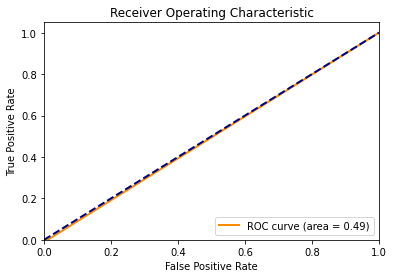

In [ ]:
plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

In [ ]:
model.save('model_2.h5')

ROC curve probabilitas yang memplot tingkat true-positive rate (TPR) terhadap false-positive rate (FPR). didalam kurva ini, garis diagonal adalah kurva untuk random guessing, seperti coin flipping, jadi ROC curve di atas menunjukkan bahwa model lebih baik daripada kemungkinan melakukan classifying diantara dandelions dan rumput. GOOD!

Demikian pula, AUC (area di bawah kurva), seperti yang ditunjukkan pada legend di atas, mengukur seberapa banyak model untuk mampu membedakan antara dua kelas, dandelion dan rumput. Semakin tinggi AUC, semakin baik model kami dalam klasifikasi.

## Making Predictions
Menggunakan model untuk melakukan predictions! Upload an image untuk melihat apakah dandelion atau rumput.

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from google.colab import files
from keras.preprocessing import image

uploaded = files.upload()

for fn in uploaded.keys():
 
  # predicting images
  path = '/content/' + fn
  img = image.load_img(path, target_size=(200, 200))
  x = image.img_to_array(img)
  plt.imshow(x/255.)
  x = np.expand_dims(x, axis=0)
  images = np.vstack([x])
  classes = model.predict(images, batch_size=10)
  print(classes[0])
  if classes[0]<0.5:
    print(fn + " ini adalah bunga dandelion")
  else:
    print(fn + " ini adalah rumput")
 

## Clean Up
Run the following cell to terminate the kernel and free memory resources:

In [ ]:
import os, signal
os.kill(os.getpid(), signal.SIGKILL)

# Activity

1. Practice coding with Google Colab atau Jupyter Notebook https://colab.research.google.com/notebooks/intro.ipynb?utm_source=scs-index#recent=true
2. Ikuti langkah langkah yang sudah di berikan
3. Ganti model neural network di atas dengan arsitektur CNN

Berikut adalah arsitektur dari CNN, bandingkan hasilnya


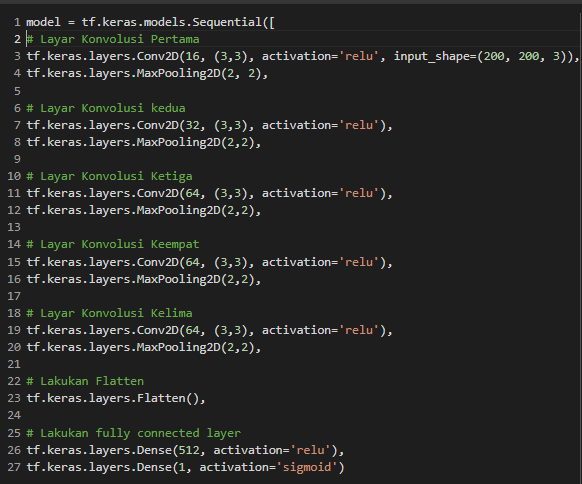